In [84]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle    


In [85]:
# Общая функция для удобного обучения и предсказания на контрольных данных
def get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium, df_contrpick, df_meta_heroes):
    
# -------- Создание основного ДФ -----------------------------------------------
       
    # Соединение всех данных в один ДФ
    main = df_rating_teams_Premium
    main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')

    # удаление не нужных колонок для обучения
    main = main.drop(['radiant_win', #'match_id', 
                'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
               'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
    main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


    
    # Выбросить весь рейтинг команд
    main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
    print (len(main))
    
# -------- Заполнить или удалить NaN и добаить коллонку с предсказаниями, обучеными ранее -----------------------------------------------       
    # Заполнить пустые значения на 0
    # main = main.fillna(0)

    # убрать пустые ячейки
    main = main.dropna()
    print(len(main))
    
# -------- Создаем новых колонок по суммам, разности показателей -----------------------------------------------    
    #------------- Для контрпиков героев --------------------------------------------------------
    main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
                main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

    # main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
    #                   main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

    #  main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
    # main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)

    #------------- Для метовых героев --------------------------------------------------------
    main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
                              main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

#     main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
#                                main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

#     main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

    # main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1)
# -------- Убрать лишние колонки -----------------------------------------------  
#     main = main.drop(['dire_H5_AvgElo',
#                      ], axis=1)
    return main

In [228]:
# Общая функция для удобного обучения и предсказания на контрольных данных
def get_main_df_for_predict(df_rating_teams_Premium, df_contrpick, df_meta_heroes, df_signatures_heroes,
                            df_features_Heroes, df_features_type_Heroes, df_predict_for_teams_rating,
                            ):
    
# -------- Создание основного ДФ -----------------------------------------------
#     df_signatures_heroes = df_signatures_heroes[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
#                                                 'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
#                                                 'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
#                                                 'dire_P5_eloShift', 'match_id']]
#     df_features_Heroes = df_features_Heroes[[ 'Sand King', 'Death Prophet', 'Gyrocopter', 
#                                              'Outworld Devourer', 'Ogre Magi', 'Disruptor', 
#                                              'match_id']]
    # Соединение всех данных в один ДФ
    main = df_rating_teams_Premium
    main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
    main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')

    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по геряом и типам героев
#     main = pd.merge(main, df_features_type_Heroes, left_on='match_id', right_on='match_id',how='left')
#     main = pd.merge(main, df_features_Heroes, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по предсказаний по алгоритму
#     main = pd.merge(main, df_predict_for_teams_rating, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------
    # Добавить фичи по Professional матчам
    # main = pd.merge(main, df_contrpick_Pro10, left_on='match_id', right_on='match_id',how='left')
    # main = pd.merge(main, df_contrpick_2MonthAgo_AllTeam1, left_on='match_id', right_on='match_id',how='left')
    # ---------------------------------------------------------------------------------------------------------------------

    # удаление не нужных колонок для обучения
    main = main.drop([#'match_id',
                      'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
               'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
    main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


    # # Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
#     main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
#     main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
#     main = main.drop(main.loc[:, 'radiant_ratingSevenDaysAgo_glicko':'radiant_ratingSevenDaysAgo_glicko2'], axis=1)
#     main = main.drop(main.loc[:, 'dire_ratingSevenDaysAgo_glicko':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
#     # Выбросить весь рейтинг команд
    main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
    print (len(main))
    
# -------- Заполнить или удалить NaN и добаить коллонку с предсказаниями, обучеными ранее -----------------------------------------------       
    # Заполнить пустые значения на 0
    # main = main.fillna(0)
    
    # убрать пустые ячейки
#     main = main.dropna()
    print(len(main))
    
# -------- Создаем новых колонок по суммам, разности показателей -----------------------------------------------    
    #------------- Для контрпиков героев --------------------------------------------------------
    main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
                main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

#     main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
#                       main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

#     main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
#     main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)
    
    #------------- Для сигнатурных героев по игрокам --------------------------------------------------------
    main['radiant_P_eloShift'] = (main['radiant_P1_eloShift'] + main['radiant_P2_eloShift'] + 
                                  main['radiant_P3_eloShift'] + main['radiant_P4_eloShift'] + main['radiant_P5_eloShift'])

    main['dire_P_eloShift'] = (main['dire_P1_eloShift'] + main['dire_P2_eloShift'] + 
                               main['dire_P3_eloShift'] + main['dire_P4_eloShift'] + main['dire_P5_eloShift'])

    main['P_eloShift'] = main['radiant_P_eloShift'] - main['dire_P_eloShift']

    main = main.drop(['radiant_P_eloShift', 'dire_P_eloShift'], axis=1)
    
    #------------- Для метовых героев --------------------------------------------------------
    main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
                              main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

    main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
                               main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

    main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

    main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1)
    #---------- Для рейтинга команд -----------------------------------------------------------
#     main['mu_glicko'] = main['radiant_mu_glicko'] -  main['dire_mu_glicko']
#     main['rating_glicko'] = main['radiant_rating_glicko'] -  main['dire_rating_glicko']
#     main['ratingSevenDaysAgo_glicko'] = main['radiant_ratingSevenDaysAgo_glicko'] -  main['dire_ratingSevenDaysAgo_glicko']
#     main['mu_glicko2'] = main['radiant_mu_glicko2'] -  main['dire_mu_glicko2']
#     main['phi_glicko2'] = main['radiant_phi_glicko2'] -  main['dire_phi_glicko2']
    # main['rating_glicko2'] = main['radiant_rating_glicko2'] -  main['dire_rating_glicko2']
    # main['ratingSevenDaysAgo_glicko2'] = main['radiant_ratingSevenDaysAgo_glicko2']-main['dire_ratingSevenDaysAgo_glicko2']
    
# -------- Создаем новых колонок по разности типов героев -----------------------------------------------        
#     main['Disabler'] = (main['Disabler1'] + main['Disabler2'] + main['Disabler3'] + main['Disabler4'] + main['Disabler5'] - 
#                    main['Disabler6'] - main['Disabler7'] - main['Disabler8'] - main['Disabler9'] - main['Disabler10'])

#     main['Nuker'] = (main['Nuker1'] + main['Nuker2'] + main['Nuker3'] + main['Nuker4'] + main['Nuker5'] - 
#                        main['Nuker6'] - main['Nuker7'] - main['Nuker8'] - main['Nuker9'] - main['Nuker10'])

#     main['Carry'] = (main['Carry1'] + main['Carry2'] + main['Carry3'] + main['Carry4'] + main['Carry5'] - 
#                        main['Carry6'] - main['Carry7'] - main['Carry8'] - main['Carry9'] - main['Carry10'])

#     main['Initiator'] = (main['Initiator1'] + main['Initiator2'] + main['Initiator3']+main['Initiator4']+main['Initiator5'] - 
#                     main['Initiator6'] - main['Initiator7'] - main['Initiator8'] - main['Initiator9'] - main['Initiator10'])

#     main['Escape'] = (main['Escape1'] + main['Escape2'] + main['Escape3'] + main['Escape4'] + main['Escape5'] - 
#                        main['Escape6'] - main['Escape7'] - main['Escape8'] - main['Escape9'] - main['Escape10'])

#     main['Durable'] = (main['Durable1'] + main['Durable2'] + main['Durable3'] + main['Durable4'] + main['Durable5'] - 
#                        main['Durable6'] - main['Durable7'] - main['Durable8'] - main['Durable9'] - main['Durable10'])

#     main['Support'] = (main['Support1'] + main['Support2'] + main['Support3'] + main['Support4'] + main['Support5'] - 
#                        main['Support6'] - main['Support7'] - main['Support8'] - main['Support9'] - main['Support10'])

#     main['Pusher'] = (main['Pusher1'] + main['Pusher2'] + main['Pusher3'] + main['Pusher4'] + main['Pusher5'] - 
#                        main['Pusher6'] - main['Pusher7'] - main['Pusher8'] - main['Pusher9'] - main['Pusher10'])

#     main['Jungler'] = (main['Jungler1'] + main['Jungler2'] + main['Jungler3'] + main['Jungler4'] + main['Jungler5'] - 
#                        main['Jungler6'] - main['Jungler7'] - main['Jungler8'] - main['Jungler9'] - main['Jungler10'])
#     main = main.drop(['attac_type1','Disabler1','Nuker1','Carry1','Initiator1','Escape1','Durable1','Support1','Pusher1',
#                       'Jungler1',
#             'attac_type2','Disabler2','Nuker2','Carry2','Initiator2','Escape2','Durable2','Support2','Pusher2','Jungler2',
#             'attac_type3','Disabler3','Nuker3','Carry3','Initiator3','Escape3','Durable3','Support3','Pusher3','Jungler3',
#             'attac_type4','Disabler4','Nuker4','Carry4','Initiator4','Escape4','Durable4','Support4','Pusher4','Jungler4',
#             'attac_type5','Disabler5','Nuker5','Carry5','Initiator5','Escape5','Durable5','Support5','Pusher5','Jungler5',
#             'attac_type6','Disabler6','Nuker6','Carry6','Initiator6','Escape6','Durable6','Support6','Pusher6','Jungler6',
#             'attac_type7','Disabler7','Nuker7','Carry7','Initiator7','Escape7','Durable7','Support7','Pusher7','Jungler7',
#             'attac_type8','Disabler8','Nuker8','Carry8','Initiator8','Escape8','Durable8','Support8','Pusher8','Jungler8',
#             'attac_type9','Disabler9','Nuker9','Carry9','Initiator9','Escape9','Durable9','Support9','Pusher9','Jungler9',
#          'attac_type10','Disabler10','Nuker10','Carry10','Initiator10','Escape10','Durable10','Support10','Pusher10',
#                       'Jungler10'], axis=1)

# # # -------- Стандартизация показателей -----------------------------------------------     
#     scaler = StandardScaler()
#     main['Disabler'] = scaler.fit(pd.DataFrame(main['Disabler'])).transform(pd.DataFrame(main['Disabler']))
#     main['Nuker'] = scaler.fit(pd.DataFrame(main['Nuker'])).transform(pd.DataFrame(main['Nuker']))
#     main['Carry'] = scaler.fit(pd.DataFrame(main['Carry'])).transform(pd.DataFrame(main['Carry']))
#     main['Initiator'] = scaler.fit(pd.DataFrame(main['Initiator'])).transform(pd.DataFrame(main['Initiator']))
#     main['Escape'] = scaler.fit(pd.DataFrame(main['Escape'])).transform(pd.DataFrame(main['Escape']))
#     main['Durable'] = scaler.fit(pd.DataFrame(main['Durable'])).transform(pd.DataFrame(main['Durable']))
#     main['Support'] = scaler.fit(pd.DataFrame(main['Support'])).transform(pd.DataFrame(main['Support']))
#     main['Pusher'] = scaler.fit(pd.DataFrame(main['Pusher'])).transform(pd.DataFrame(main['Pusher']))
#     main['Jungler'] = scaler.fit(pd.DataFrame(main['Jungler'])).transform(pd.DataFrame(main['Jungler']))
    
#     main['radiant_elo_vs_enemies'] = scaler.fit(pd.DataFrame(
#         main['radiant_elo_vs_enemies'])).transform(pd.DataFrame(main['radiant_elo_vs_enemies']))       
#     main['radiant_P_eloShift'] = scaler.fit(pd.DataFrame(
#         main['radiant_P_eloShift'])).transform(pd.DataFrame(main['radiant_P_eloShift']))
#     main['dire_P_eloShift'] = scaler.fit(pd.DataFrame(
#         main['dire_P_eloShift'])).transform(pd.DataFrame(main['dire_P_eloShift']))
#     main['P_eloShift'] = scaler.fit(pd.DataFrame(main['P_eloShift'])).transform(pd.DataFrame(main['P_eloShift']))
#     main['radiant_H_AvgElo'] = scaler.fit(pd.DataFrame(
#         main['radiant_H_AvgElo'])).transform(pd.DataFrame(main['radiant_H_AvgElo']))
#     main['dire_H_AvgElo'] = scaler.fit(pd.DataFrame(main['dire_H_AvgElo'])).transform(pd.DataFrame(main['dire_H_AvgElo']))
#     main['H_AvgElo'] = scaler.fit(pd.DataFrame(main['H_AvgElo'])).transform(pd.DataFrame(main['H_AvgElo']))
#     main['mu_glicko'] = scaler.fit(pd.DataFrame(main['mu_glicko'])).transform(pd.DataFrame(main['mu_glicko']))
#     main['rating_glicko'] = scaler.fit(pd.DataFrame(main['rating_glicko'])).transform(pd.DataFrame(main['rating_glicko']))
#     main['ratingSevenDaysAgo_glicko'] = scaler.fit(pd.DataFrame(
#         main['ratingSevenDaysAgo_glicko'])).transform(pd.DataFrame(main['ratingSevenDaysAgo_glicko']))
#     main['mu_glicko2'] = scaler.fit(pd.DataFrame(main['mu_glicko2'])).transform(pd.DataFrame(main['mu_glicko2']))
#     main['phi_glicko2'] = scaler.fit(pd.DataFrame(main['phi_glicko2'])).transform(pd.DataFrame(main['phi_glicko2']))

# -------- Убрать лишние колонки -----------------------------------------------  
    main = main.drop([# 'Jungler', 'Pusher', 'Initiator', 'Escape', 'Nuker',
                      # 'radiant_mu_glicko', 'dire_mu_glicko', 
                      # 'radiant_rating_glicko', 'dire_rating_glicko', 
                      # 'radiant_sigma_glicko', 'dire_sigma_glicko',
                      # 'radiant_ratingSevenDaysAgo_glicko', 'dire_ratingSevenDaysAgo_glicko',
                      # 'radiant_mu_glicko2', 'dire_mu_glicko2', 
                      # 'radiant_phi_glicko2', 'dire_phi_glicko2',
                      # 'radiant_rating_glicko2', 'dire_rating_glicko2', 
                      # 'radiant_sigma_glicko2', 'dire_sigma_glicko2',
                      # 'radiant_ratingSevenDaysAgo_glicko2', 'dire_ratingSevenDaysAgo_glicko2',
                      # 'dire_H5_AvgElo', 'radiant_H1_AvgElo',
                      #  'dire_P5_eloShift',
                     ], axis=1)
    return main

# Подгрузка всех таблиц с данными по матчам

In [203]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                          'PREMIUM on 2012-02-28 to 2018-03-01 (PreDay).csv', index_col=0)

# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, All, more 20).csv', index_col=0)

# ДФ с метовыми героями (PRO, >10)
df_meta_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 20).csv', index_col=0)

# ДФ с сигнатурками для каждого игрока (ALL, >5)
df_signatures_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                                   'Players Signatures on 2012-02-28 to 2018-03-01 (PreDay, All, more 5).csv', index_col=0)

# ---------------------------------------------------------------------------------------------------------------------
# df_contrpick_Pro10 = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, Pro, more 10).csv', index_col=0)

# df_contrpick_2MonthAgo_AllTeam1 = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 1).csv', index_col=0)

# Подгрузка данных по фичам с геряоми

In [204]:
# дф с матчами где по каждому героя своя фича (Премиум)
df_features_Heroes = pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
                                      'PREMIUM on 2012-02-28 to 2018-03-01.csv', index_col=0)
# дф с матчами где фичи тип атаки, дизейблер, нюкер, керри и другие (Премиум)
df_features_type_Heroes = pd.read_csv('../tabel/table from Datdota/Features carry, support, necker/'+
                                      'PREMIUM on 2012-02-28 to 2018-03-01.csv', index_col=0)
# дф с предсказаниями по алгоритму, обученому только на рейтинге команд
df_predict_for_teams_rating = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'Predict for rating teams on 2012-02-28 to 2018-03-01.csv', index_col=0)


# Подгрузка данных с Премиум матчей

In [121]:
# # ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
# df_contrpick_Premium = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, Pro, more 20).csv', index_col=0)

# # ДФ с метовыми героями (PRO, >10)
# df_meta_heroes_premium = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, Pro, more 20).csv', index_col=0)

In [122]:
# main_Premium = get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium, df_contrpick_Premium, df_meta_heroes_premium)


In [123]:
# main_Premium.columns

# Подгрузка и сборка всех данных до 26 апреля 

In [124]:
# # Соединить все данные и бучить на всех
# df_rating_teams_Premium = pd.concat([df_rating_teams_Premium, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'PREMIUM on 2018-03-01 to 2018-04-08 (PreDay).csv', index_col=0)])
# df_rating_teams_Premium = pd.concat([df_rating_teams_Premium, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'PREMIUM on 2018-04-08 to 2018-04-25 (PreDay).csv', index_col=0)])

# df_contrpick = pd.concat([df_contrpick, pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2018-03-01 to 2018-04-08 (PreDay, All, more 20).csv', index_col=0)])
# df_contrpick = pd.concat([df_contrpick, pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-last. on 2018-04-08 to 2018-04-25 (PreDay, All, more 20).csv', index_col=0)])

# df_meta_heroes = pd.concat([df_meta_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2018-03-01 to 2018-04-08 (TwoMonthAgo, All, more 20).csv', index_col=0)])
# df_meta_heroes = pd.concat([df_meta_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Meta on 2018-04-08 to 2018-04-25 (TwoMonthAgo, All, more 20).csv', index_col=0)])

# df_signatures_heroes = pd.concat([df_signatures_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                 'Players Signatures on 2018-03-01 to 2018-04-08 (PreDay, All, more 5).csv', index_col=0)])
# df_signatures_heroes = pd.concat([df_signatures_heroes, pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                 'Players Signatures on 2018-04-08 to 2018-04-25 (PreDay, All, more 5).csv', index_col=0)])

# df_features_Heroes = pd.concat([df_features_Heroes, pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
#                                       'PREMIUM on 2018-03-01 to 2018-04-08.csv', index_col=0)])
# df_features_Heroes = pd.concat([df_features_Heroes, pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
#                                       'PREMIUM on 2018-04-08 to 2018-04-25.csv', index_col=0)])

# df_predict_for_teams_rating = pd.concat([df_predict_for_teams_rating, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'Predict for rating teams on 2018-03-01 to 2018-04-08.csv', index_col=0)])
# df_predict_for_teams_rating = pd.concat([df_predict_for_teams_rating, pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'Predict for rating teams on 2018-04-08 to 2018-04-25.csv', index_col=0)])

# Создание обучающих и тестовых данных

In [229]:
main = get_main_df_for_predict(df_rating_teams_Premium, df_contrpick, df_meta_heroes, df_signatures_heroes,
                            df_features_Heroes, df_features_type_Heroes, df_predict_for_teams_rating,
                              )

3602
3602


In [230]:
# main = pd.merge(main, main_Premium, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_predict_signatures, left_on='match_id', right_on='match_id',how='left')
main = main.dropna()

In [231]:
# сделать обучающие данные и ответы
X = main.drop(['radiant_win', 'match_id'], axis=1)

y = main['radiant_win']
#-------------------------------------

# ---------------------------------------
# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
X_train.columns

Index(['radiant_H1_elo_vs_enemies', 'radiant_H2_elo_vs_enemies',
       'radiant_H3_elo_vs_enemies', 'radiant_H4_elo_vs_enemies',
       'radiant_H5_elo_vs_enemies', 'dire_H1_elo_vs_enemies',
       'dire_H2_elo_vs_enemies', 'dire_H3_elo_vs_enemies',
       'dire_H4_elo_vs_enemies', 'dire_H5_elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift', 'radiant_P1_gpm', 'radiant_P1_xpm',
       'radiant_P1_kda', 'radiant_P2_eloShift', 'radiant_P2_gpm',
       'radiant_P2_xpm', 'radiant_P2_kda', 'radiant_P3_eloShift',
       'radiant_P3_gpm', 'radiant_P3_xpm', 'radiant_P3_kda',
       'radiant_P4_eloShift', 'radiant_P4_gpm', 'radiant_P4_xpm',
       'radiant_P4_kda', 'radiant_P5_eloShift', 'radiant_P5_gpm',
       'radiant_P5_xpm', 'radiant_P5_kda', 'dire_P1_eloShift', 'dire_P1_gpm',
     

# Обучение

In [232]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
print(classification_report(y_test, XGB.predict(X_test), target_names=['dire_win', 'radiant_win']))

gb_auc = metrics.roc_auc_score(y_test, XGB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.69      0.68      0.68       416
radiant_win       0.70      0.72      0.71       447

avg / total       0.70      0.70      0.70       863

AUC для градиентного бустинга - 0.751
Wall time: 227 ms


In [184]:
# precision    recall  f1-score   support

#    dire_win       0.74      0.73      0.74       416
# radiant_win       0.75      0.76      0.76       447

# avg / total       0.75      0.75      0.75       863

# AUC для градиентного бустинга - 0.834
# Wall time: 205 ms

XGB_signatures = XGB
X_signatures = XGB_signatures.predict_proba(X)[:,1]


In [199]:
df_predict_signatures = pd.DataFrame(main['match_id'])
df_predict_signatures['Pred_signatures'] = X_signatures


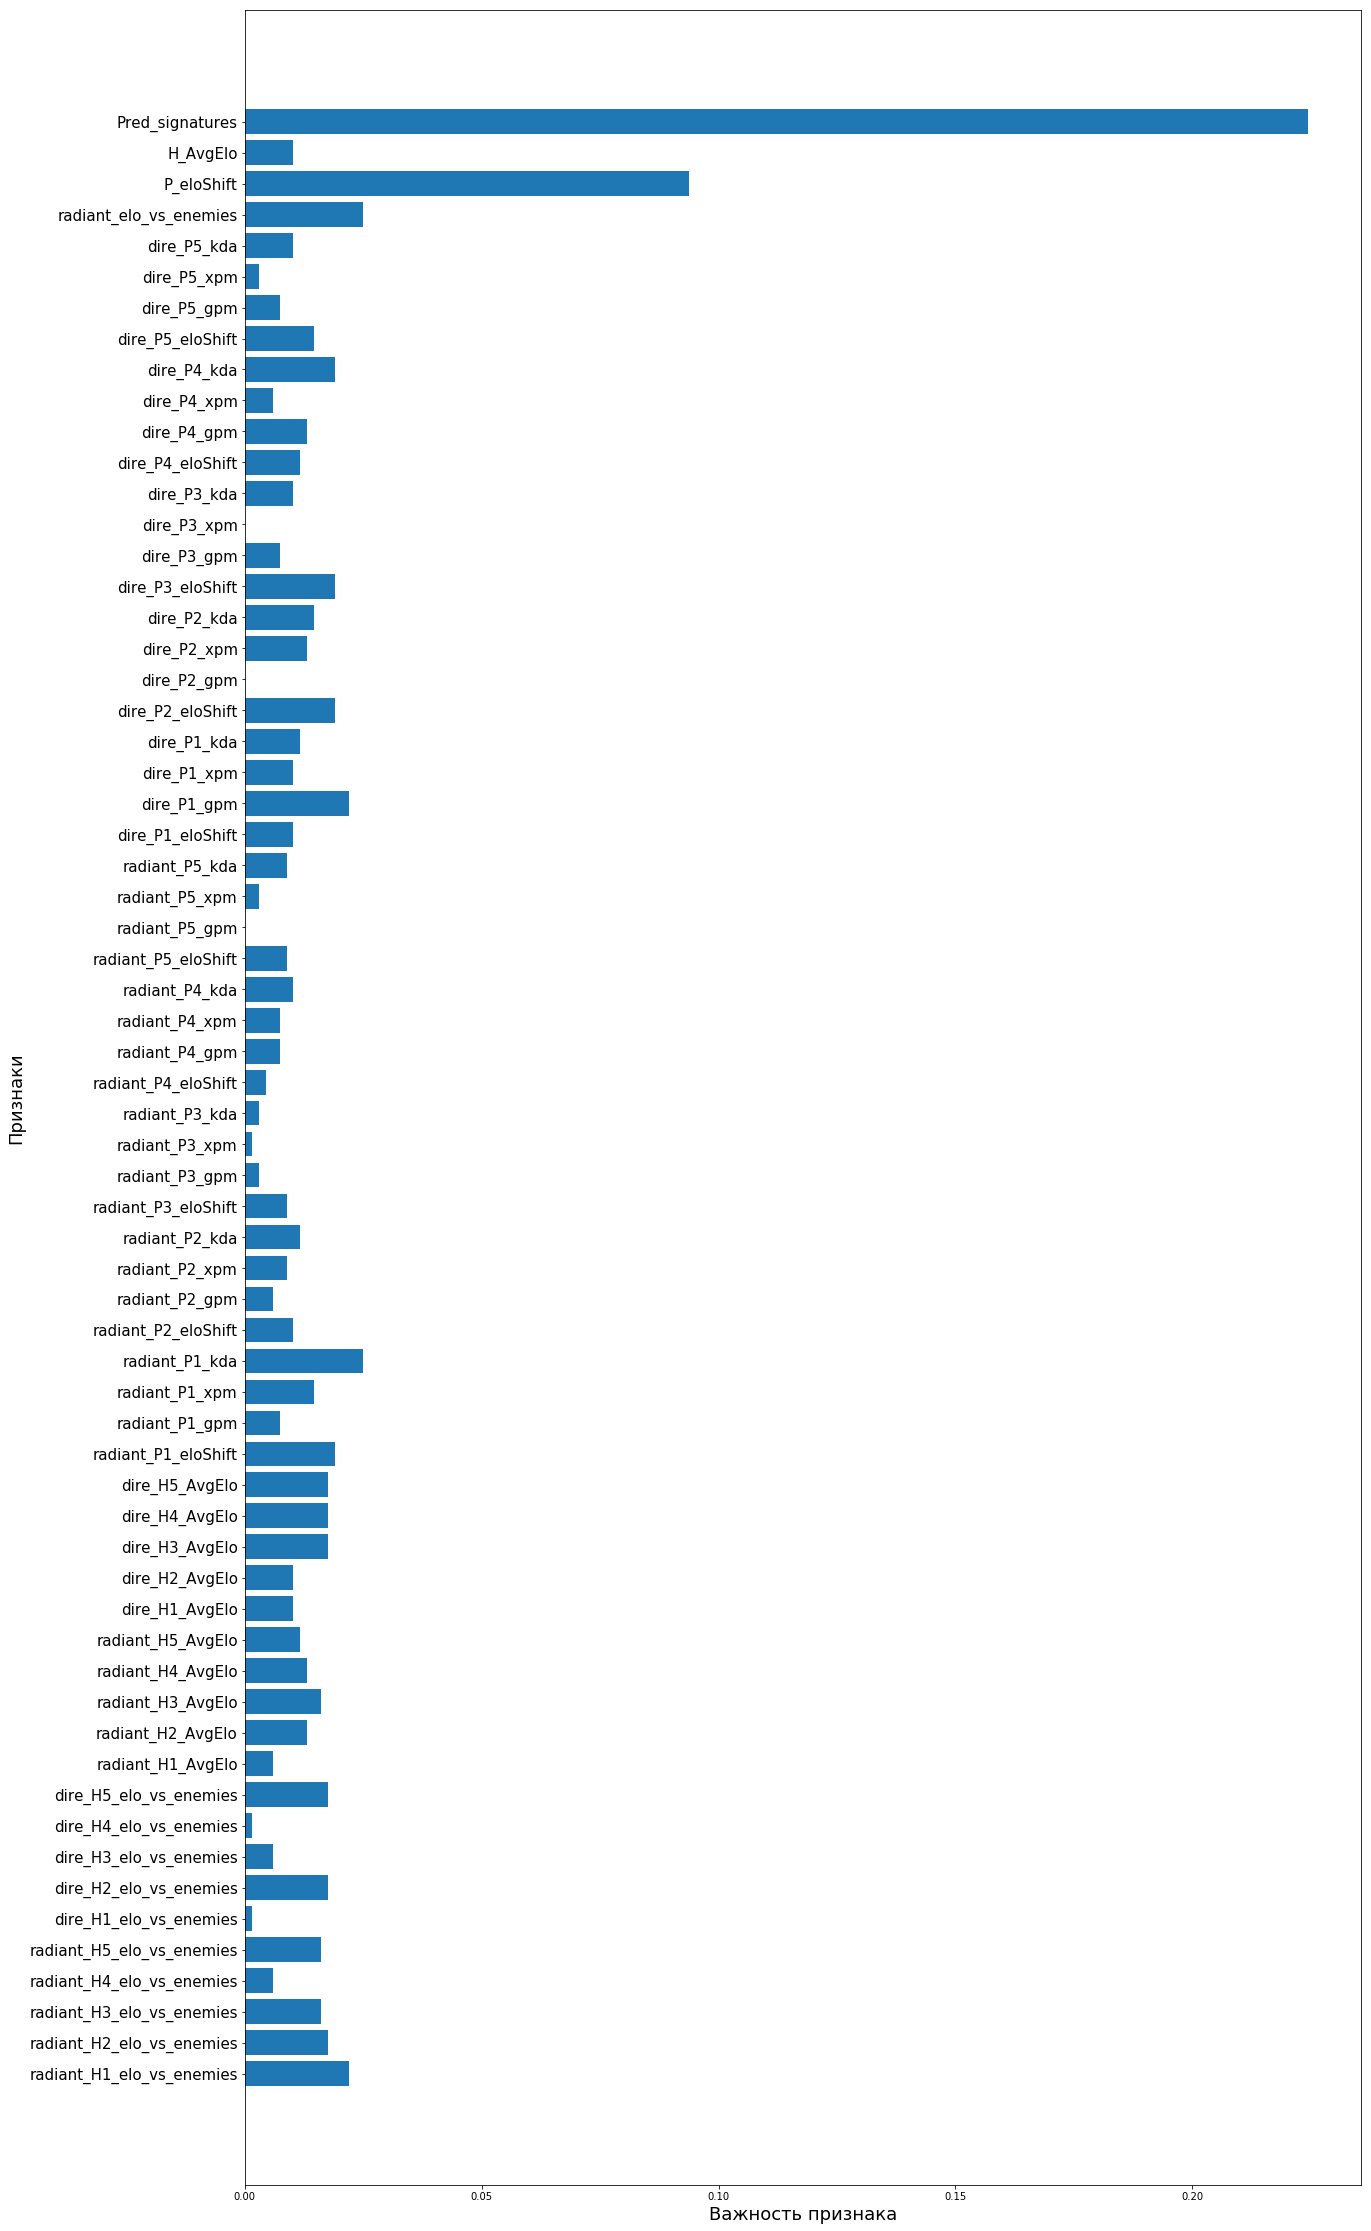

In [233]:
# важность признаков в бустинге

n_features = X_train.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [206]:
# # save the model to disk
# filename = 'xgb.v.1.3.b.75.sav'
# pickle.dump(XGB, open(filename, 'wb'))

In [258]:
# # Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
# df_pedict_for_rating_teams = pd.DataFrame(XGB.predict_proba(X)[:,1:], columns=['Predict'])
# df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium['match_id'].reset_index().drop('index', axis=1)
# df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/'+
#                            'Predict Pro on 2012-02-28 to 2018-03-01.csv')

In [15]:
# test_gb = pickle.load(open('Xgboost_model_predict_rating_teams', 'rb'))
# test_gb.score(X_test, y_test)

# Решетчатый поиск на Gradient Bosting

In [115]:
%%time
# Праметры GB
# param_grid = {'n_estimators': [25, 50, 100, 150], 'max_depth': [10, 25, 50, 100],
#               'max_features': [50, 100, 200, 300]}
param_grid = {'n_estimators': [100], 'max_depth': [10],
              'max_features': [30]}
grid_search_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search_GB.fit(X_train,y_train)


print("Наилучшие значения параметров: {}".format(grid_search_GB.best_params_))
print('----------------------------------------------------------------------')
print(classification_report(y_test, grid_search_GB.predict(X_test), target_names=['dire_win', 'radiant_win']))

# Проверка на новых данных

In [234]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2018-03-01 to 2018-04-08 (PreDay).csv', index_col=0)

# ДФ с контрпиками
df_contrpick_contr = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2018-03-01 to 2018-04-08 (PreDay, All, more 20).csv'), index_col=0)

# ДФ с метовыми героями 
df_meta_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2018-03-01 to 2018-04-08 (TwoMonthAgo, All, more 20).csv', index_col=0)

# ДФ с сигнатурками для каждого игрока (ALL, >5)
df_signatures_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                    'Players Signatures on 2018-03-01 to 2018-04-08 (PreDay, All, more 5).csv', index_col=0)


In [235]:
# дф с матчами где по каждому героя своя фича (Премиум)
df_features_Heroes_contr = pd.read_csv('../tabel/table from Datdota/Features Heroes/'+
                                      'PREMIUM on 2018-03-01 to 2018-04-08.csv', index_col=0)
# дф с матчами где фичи тип атаки, дизейблер, нюкер, керри и другие (Премиум)
df_features_type_Heroes_contr = pd.read_csv('../tabel/table from Datdota/Features carry, support, necker/'+
                                      'PREMIUM on 2018-03-01 to 2018-04-08.csv', index_col=0)
# дф с предсказаниями по алгоритму, обученому только на рейтинге команд
df_predict_for_teams_rating_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'Predict for rating teams on 2018-03-01 to 2018-04-08.csv', index_col=0)

In [222]:
# df_rating_teams_Premium_contr =df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['league_name'] == 
#                                                              'Dota 2 Asia Championships 2018']
# pd.set_option('display.max_columns', 500)

# Подгрузка данных с Премиум матчей

In [134]:
# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick_premium_contr = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2018-03-01 to 2018-04-08 (PreDay, Pro, more 20).csv', index_col=0)

# ДФ с метовыми героями (PRO, >10)
df_meta_heroes_premium_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2018-03-01 to 2018-04-08 (TwoMonthAgo, Pro, more 20).csv', index_col=0)

In [135]:
contr_Premium = get_main_df_for_predict_for_ProTeams(df_rating_teams_Premium_contr,
                                                    df_contrpick_premium_contr, df_meta_heroes_premium_contr)


451
451


In [136]:
contr_Premium.columns

Index(['match_id', 'radiant_H1_elo_vs_enemies', 'radiant_H2_elo_vs_enemies',
       'radiant_H3_elo_vs_enemies', 'radiant_H4_elo_vs_enemies',
       'radiant_H5_elo_vs_enemies', 'dire_H1_elo_vs_enemies',
       'dire_H2_elo_vs_enemies', 'dire_H3_elo_vs_enemies',
       'dire_H4_elo_vs_enemies', 'dire_H5_elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_elo_vs_enemies', 'radiant_H_AvgElo'],
      dtype='object')

# Создание обучающих и тестовых данных

In [236]:
contr = get_main_df_for_predict(df_rating_teams_Premium_contr, df_contrpick_contr, df_meta_heroes_contr, df_signatures_heroes_contr,
                            df_features_Heroes_contr, df_features_type_Heroes_contr, df_predict_for_teams_rating_contr,
                              )

451
451


In [237]:
# contr = pd.merge(contr, contr_Premium, left_on='match_id', right_on='match_id',how='left')
contr = pd.merge(contr, df_predict_signatures_contr, left_on='match_id', right_on='match_id',how='left')
contr = contr.dropna()

In [238]:
# Создание контрольной выборки
# Cделать обучающие данные и ответы
X_contr = contr.drop(['radiant_win', 'match_id'], axis=1)
y_contr = contr['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)
X_contr.columns

Index(['radiant_H1_elo_vs_enemies', 'radiant_H2_elo_vs_enemies',
       'radiant_H3_elo_vs_enemies', 'radiant_H4_elo_vs_enemies',
       'radiant_H5_elo_vs_enemies', 'dire_H1_elo_vs_enemies',
       'dire_H2_elo_vs_enemies', 'dire_H3_elo_vs_enemies',
       'dire_H4_elo_vs_enemies', 'dire_H5_elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift', 'radiant_P1_gpm', 'radiant_P1_xpm',
       'radiant_P1_kda', 'radiant_P2_eloShift', 'radiant_P2_gpm',
       'radiant_P2_xpm', 'radiant_P2_kda', 'radiant_P3_eloShift',
       'radiant_P3_gpm', 'radiant_P3_xpm', 'radiant_P3_kda',
       'radiant_P4_eloShift', 'radiant_P4_gpm', 'radiant_P4_xpm',
       'radiant_P4_kda', 'radiant_P5_eloShift', 'radiant_P5_gpm',
       'radiant_P5_xpm', 'radiant_P5_kda', 'dire_P1_eloShift', 'dire_P1_gpm',
     

In [239]:
print(classification_report(y_contr, XGB.predict(X_contr), target_names=['dire_win', 'radiant_win']))
gb_auc = metrics.roc_auc_score(y_contr, XGB.predict_proba(X_contr)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

             precision    recall  f1-score   support

   dire_win       0.50      0.58      0.54       179
radiant_win       0.66      0.60      0.63       250

avg / total       0.60      0.59      0.59       429

AUC для градиентного бустинга - 0.611


In [201]:
#          precision    recall  f1-score   support

#    dire_win       0.58      0.58      0.58       179
# radiant_win       0.70      0.70      0.70       250

# avg / total       0.65      0.65      0.65       429

# AUC для градиентного бустинга - 0.692
df_predict_signatures_contr = pd.DataFrame(contr['match_id'])
df_predict_signatures_contr['Pred_signatures'] = XGB.predict_proba(X_contr)[:,1]


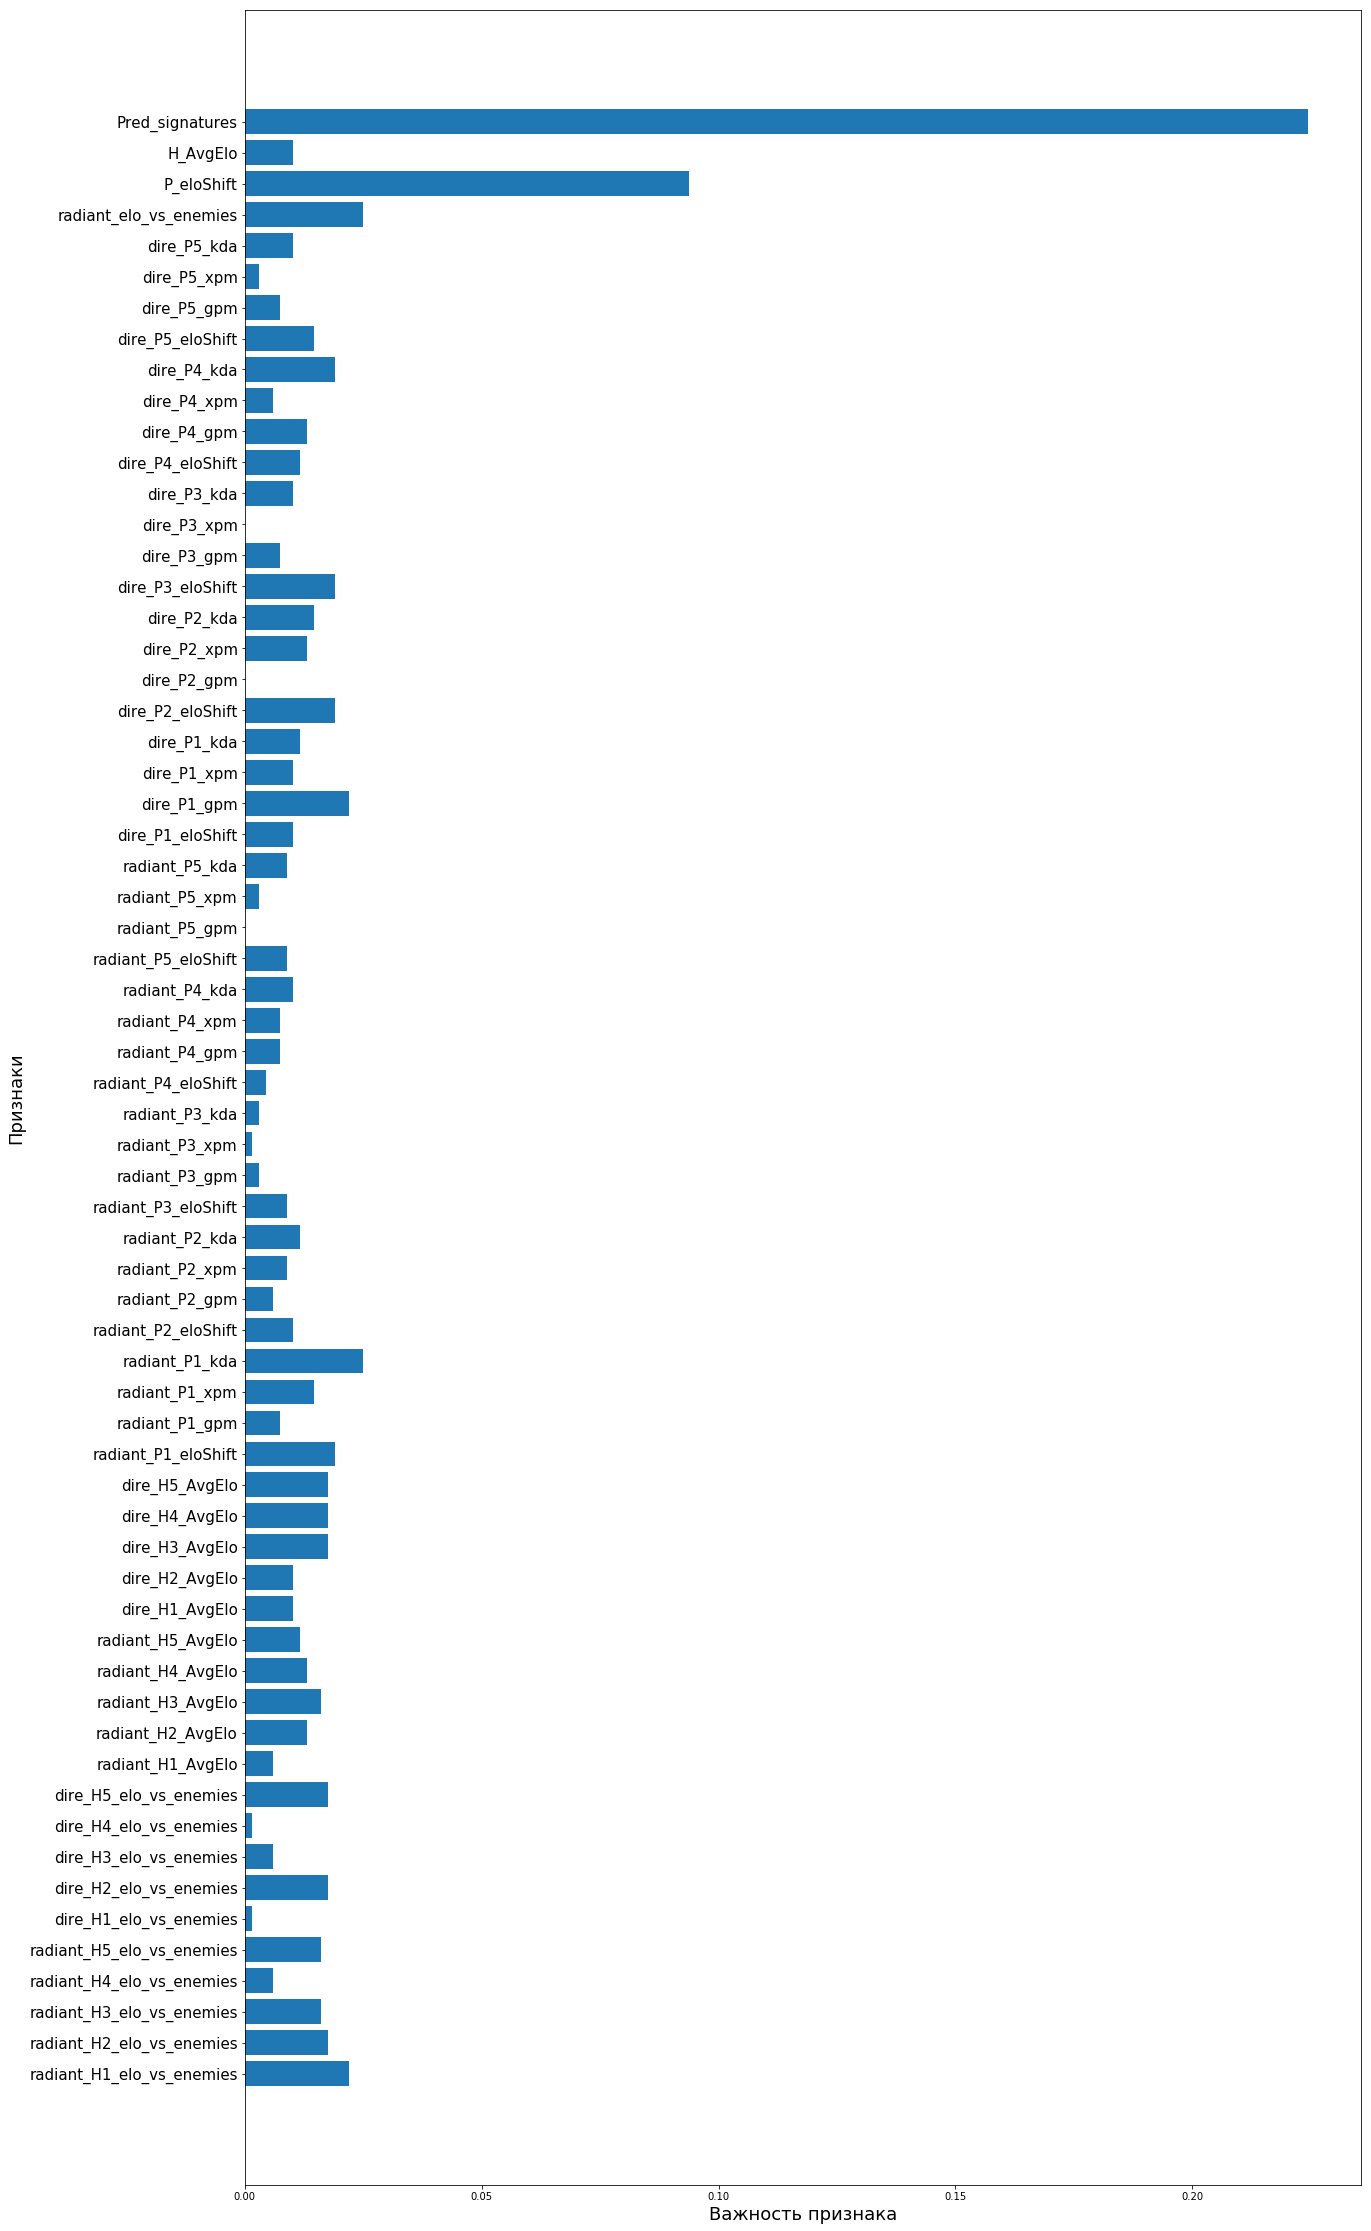

In [240]:
# важность признаков в бустинге

n_features = X_contr.shape[1]

plt.figure(figsize=(20,40))
plt.barh(range(n_features), XGB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_contr.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [334]:
# # Создать и сохранить фичу с предсказаниями по алгоритму, обученому на рейтинге команд
# df_pedict_for_rating_teams = pd.DataFrame(XGB.predict_proba(X_contr)[:,1:], columns=['Predict'])
# df_pedict_for_rating_teams['match_id'] = df_rating_teams_Premium_contr['match_id'].reset_index().drop('index', axis=1)
# df_pedict_for_rating_teams.to_csv('../tabel/table from Datdota/'+
#                            'Predict Pro on 2018-03-01 to 2018-04-08.csv')

# Подгрузка данных по матчам Professional

In [140]:
# # Работа с данными Professional
# # ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
# df_contrpick_Pro = pd.read_csv('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'Professional data from 6.74-last. on 2012-02-28 to 2018-03-01 (PreDay, All, more 20).csv', index_col=0)
# # ДФ с метовыми героями (PRO, >10)
# df_meta_heroes_Pro = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                              'Professional Meta on 2012-02-28 to 2018-03-01 (TwoMonthAgo, All, more 20).csv', index_col=0)

# # ДФ с сигнатурками для каждого игрока (ALL, >5)
# df_signatures_heroes_Pro = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
#                                    'Professional Players Signatures on 2012-02-28 to 2018-03-01 (All, more 5) (previosly day).csv', index_col=0)

In [141]:
def replace_in_columns_to_mean(df ):
    # Заменить 0.0 во всех колонках на среднее значение
    # посчитать среднее значение для elo игрока
    a = []
    H_or_P = df.columns[0].split('_')[1][0]
    end_name_columns = df.columns[0][( df.columns[0].find('_')+3):]
    for i in range (1,6):
        a.append(df[('radiant_{}{}'+end_name_columns).format(H_or_P, i)].mean())
    #     print(df_contrpick['radiant_H{}elo_vs_enemies'.format(i)].value_counts().head())

        a.append(df[('dire_{}{}'+end_name_columns).format(H_or_P, i)].mean())
    #     print(df_contrpick['dire_H{}elo_vs_enemies'.format(i)].value_counts().head())
    mean_Players = np.array(a).mean()
    print(mean_Players)
    # заменить все значения 0.0 в elo игрока на среднее значение
    for i in range (1,6):
        df[('radiant_{}{}'+end_name_columns).format(H_or_P, i)] = df[('radiant_{}{}'+end_name_columns
                                                            ).format(H_or_P, i)].replace(0, mean_Players)

        df[('dire_{}{}'+end_name_columns).format(H_or_P, i)] = df[('dire_{}{}'+end_name_columns
                                                         ).format(H_or_P, i)].replace(0, mean_Players)  

In [142]:
# replace_in_columns_to_mean(df_signatures_heroes)
# replace_in_columns_to_mean(df_signatures_heroes_Pro, '_eloShift')

In [143]:
# for i in range (1,6):
#         print(df_contrpick['radiant_H{}_elo_vs_enemies'.format(i)].value_counts().head())
#         print(df_contrpick['dire_H{}_elo_vs_enemies'.format(i)].value_counts().head())

In [144]:
# df_signatures_heroes_Pro = df_signatures_heroes_Pro[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
#                                             'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
#                                             'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
#                                             'dire_P5_eloShift', 'match_id']].fillna(mean_Players)

# # Соединение всех данных в один ДФ
# main2 = pd.read_csv('../tabel/'+
#                 'Proffesional on patch 7.01 to 2018-03-01 (match_id).csv')
# # main2 = pd.merge(main2, df_contrpick_Pro, left_on='match_id', right_on='match_id',how='left')
# # main2 = pd.merge(main2, df_meta_heroes_Pro, left_on='match_id', right_on='match_id',how='left')
# main2 = pd.merge(main2, df_signatures_heroes_Pro, left_on='match_id', right_on='match_id',how='left')

# # # удаление не нужных колонок для обучения
# main2 = main2.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
#            'dire_score'], axis=1)

# print (len(main2))
# main2.columns

In [145]:
# main = df_signatures_heroes
# print (len(main))
# main.columns

# Старые проверки и работы

# Создание основного ДФ для обучения и предсказания

In [122]:
df_signatures_heroes = df_signatures_heroes[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
                                            'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
                                            'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
                                            'dire_P5_eloShift', 'match_id']]

# Соединение всех данных в один ДФ
main = df_rating_teams_Premium
main = pd.merge(main, df_contrpick, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')

# ---------------------------------------------------------------------------------------------------------------------
# Добавить фичи по геряом и типам героев
# main = pd.merge(main, df_features_type_Heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_features_Heroes, left_on='match_id', right_on='match_id',how='left')
# ---------------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------------
# Добавить фичи по Professional матчам
# main = pd.merge(main, df_contrpick_Pro10, left_on='match_id', right_on='match_id',how='left')
# main = pd.merge(main, df_contrpick_2MonthAgo_AllTeam1, left_on='match_id', right_on='match_id',how='left')
# ---------------------------------------------------------------------------------------------------------------------

# удаление не нужных колонок для обучения
main = main.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


# # Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
# main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
# main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
# main = main.drop(main.loc[:, 'radiant_ratingSevenDaysAgo_glicko':'radiant_ratingSevenDaysAgo_glicko2'], axis=1)
# main = main.drop(main.loc[:, 'dire_ratingSevenDaysAgo_glicko':'dire_ratingSevenDaysAgo_glicko2'], axis=1)
# Выбросить весь рейтинг команд
main = main.drop(main.loc[:, 'radiant_current_elo32':'dire_ratingSevenDaysAgo_glicko2'], axis=1)

print (len(main))
# main.columns

3602


In [78]:
print(main.loc[2000, "radiant_rating_glicko2"])
datetime.date.fromtimestamp(1506788216)

1728.34025281


datetime.date(2017, 9, 30)

In [102]:
df_signatures_heroes[df_signatures_heroes['match_id']== 3475124948].loc[:, :]

,radiant_P1_eloShift,radiant_P2_eloShift,radiant_P3_eloShift,radiant_P4_eloShift,radiant_P5_eloShift,dire_P1_eloShift,dire_P2_eloShift,dire_P3_eloShift,dire_P4_eloShift,dire_P5_eloShift,match_id
2000,3.795196,-4.318838,0.0,-5.28387,0.0,0.0,0.0,4.273999,2.530319,-11.045056,3475124948


In [124]:
# Заполнить пустые значения на 0
# main = main.fillna(0)

main['Predict'] = predict_for_rating_teams
# убрать пустые ячейки
main = main.dropna()
len(main)

3452

In [125]:
main.columns

Index(['radiant_win', 'radiant_H1_elo_vs_enemies', 'radiant_H2_elo_vs_enemies',
       'radiant_H3_elo_vs_enemies', 'radiant_H4_elo_vs_enemies',
       'radiant_H5_elo_vs_enemies', 'dire_H1_elo_vs_enemies',
       'dire_H2_elo_vs_enemies', 'dire_H3_elo_vs_enemies',
       'dire_H4_elo_vs_enemies',
       ...
       'Underlord', 'Terrorblade', 'Phoenix', 'Oracle', 'Winter Wyvern',
       'Arc Warden', 'Monkey King', 'Dark Willow', 'Pangolier', 'Predict'],
      dtype='object', length=147)

In [127]:
# Создаем новые колонуи по суммам, разности показателей
main['radiant_elo_vs_enemies'] = (main['radiant_H1_elo_vs_enemies'] + main['radiant_H2_elo_vs_enemies'] + 
                main['radiant_H3_elo_vs_enemies'] + main['radiant_H4_elo_vs_enemies'] + main['radiant_H5_elo_vs_enemies'])

# main['dire_elo_vs_enemies'] = (main['dire_H1_elo_vs_enemies'] + main['dire_H2_elo_vs_enemies'] + 
#                             main['dire_H3_elo_vs_enemies'] + main['dire_H4_elo_vs_enemies'] + main['dire_H5_elo_vs_enemies'])

# main['elo_vs_enemies'] = main['radiant_elo_vs_enemies'] - main['dire_elo_vs_enemies']
# main = main.drop(['radiant_elo_vs_enemies', 'dire_elo_vs_enemies'], axis=1)

main['radiant_P_eloShift'] = (main['radiant_P1_eloShift'] + main['radiant_P2_eloShift'] + 
                              main['radiant_P3_eloShift'] + main['radiant_P4_eloShift'] + main['radiant_P5_eloShift'])

main['dire_P_eloShift'] = (main['dire_P1_eloShift'] + main['dire_P2_eloShift'] + 
                           main['dire_P3_eloShift'] + main['dire_P4_eloShift'] + main['dire_P5_eloShift'])

main['P_eloShift'] = main['radiant_P_eloShift'] - main['dire_P_eloShift']

# main = main.drop(['radiant_P_eloShift', 'dire_P_eloShift'], axis=1)

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [128]:
main['radiant_H_AvgElo'] = (main['radiant_H1_AvgElo'] + main['radiant_H2_AvgElo'] + 
                              main['radiant_H3_AvgElo'] + main['radiant_H4_AvgElo'] + main['radiant_H5_AvgElo'])

main['dire_H_AvgElo'] = (main['dire_H1_AvgElo'] + main['dire_H2_AvgElo'] + 
                           main['dire_H3_AvgElo'] + main['dire_H4_AvgElo'] + main['dire_H5_AvgElo'])

main['H_AvgElo'] = main['radiant_H_AvgElo'] - main['dire_H_AvgElo']

# main = main.drop(['dire_H_AvgElo', 'radiant_H_AvgElo'], axis=1)

C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Apps\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [129]:
main['Disabler'] = (main['Disabler1'] + main['Disabler2'] + main['Disabler3'] + main['Disabler4'] + main['Disabler5'] - 
                   main['Disabler6'] - main['Disabler7'] - main['Disabler8'] - main['Disabler9'] - main['Disabler10'])

main['Nuker'] = (main['Nuker1'] + main['Nuker2'] + main['Nuker3'] + main['Nuker4'] + main['Nuker5'] - 
                   main['Nuker6'] - main['Nuker7'] - main['Nuker8'] - main['Nuker9'] - main['Nuker10'])

main['Carry'] = (main['Carry1'] + main['Carry2'] + main['Carry3'] + main['Carry4'] + main['Carry5'] - 
                   main['Carry6'] - main['Carry7'] - main['Carry8'] - main['Carry9'] - main['Carry10'])

main['Initiator'] = (main['Initiator1'] + main['Initiator2'] + main['Initiator3'] + main['Initiator4'] + main['Initiator5'] - 
                   main['Initiator6'] - main['Initiator7'] - main['Initiator8'] - main['Initiator9'] - main['Initiator10'])

main['Escape'] = (main['Escape1'] + main['Escape2'] + main['Escape3'] + main['Escape4'] + main['Escape5'] - 
                   main['Escape6'] - main['Escape7'] - main['Escape8'] - main['Escape9'] - main['Escape10'])

main['Durable'] = (main['Durable1'] + main['Durable2'] + main['Durable3'] + main['Durable4'] + main['Durable5'] - 
                   main['Durable6'] - main['Durable7'] - main['Durable8'] - main['Durable9'] - main['Durable10'])

main['Support'] = (main['Support1'] + main['Support2'] + main['Support3'] + main['Support4'] + main['Support5'] - 
                   main['Support6'] - main['Support7'] - main['Support8'] - main['Support9'] - main['Support10'])

main['Pusher'] = (main['Pusher1'] + main['Pusher2'] + main['Pusher3'] + main['Pusher4'] + main['Pusher5'] - 
                   main['Pusher6'] - main['Pusher7'] - main['Pusher8'] - main['Pusher9'] - main['Pusher10'])

main['Jungler'] = (main['Jungler1'] + main['Jungler2'] + main['Jungler3'] + main['Jungler4'] + main['Jungler5'] - 
                   main['Jungler6'] - main['Jungler7'] - main['Jungler8'] - main['Jungler9'] - main['Jungler10'])
main = main.drop(['attac_type1','Disabler1','Nuker1','Carry1','Initiator1','Escape1','Durable1','Support1','Pusher1','Jungler1',
           'attac_type2','Disabler2','Nuker2','Carry2','Initiator2','Escape2','Durable2','Support2','Pusher2','Jungler2',
           'attac_type3','Disabler3','Nuker3','Carry3','Initiator3','Escape3','Durable3','Support3','Pusher3','Jungler3',
           'attac_type4','Disabler4','Nuker4','Carry4','Initiator4','Escape4','Durable4','Support4','Pusher4','Jungler4',
           'attac_type5','Disabler5','Nuker5','Carry5','Initiator5','Escape5','Durable5','Support5','Pusher5','Jungler5',
           'attac_type6','Disabler6','Nuker6','Carry6','Initiator6','Escape6','Durable6','Support6','Pusher6','Jungler6',
           'attac_type7','Disabler7','Nuker7','Carry7','Initiator7','Escape7','Durable7','Support7','Pusher7','Jungler7',
           'attac_type8','Disabler8','Nuker8','Carry8','Initiator8','Escape8','Durable8','Support8','Pusher8','Jungler8',
           'attac_type9','Disabler9','Nuker9','Carry9','Initiator9','Escape9','Durable9','Support9','Pusher9','Jungler9',
     'attac_type10','Disabler10','Nuker10','Carry10','Initiator10','Escape10','Durable10','Support10','Pusher10','Jungler10'], axis=1)

KeyError: 'Disabler1'

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
main['Disabler'] = scaler.fit(pd.DataFrame(main['Disabler'])).transform(pd.DataFrame(main['Disabler']))
main['Nuker'] = scaler.fit(pd.DataFrame(main['Nuker'])).transform(pd.DataFrame(main['Nuker']))
main['Carry'] = scaler.fit(pd.DataFrame(main['Carry'])).transform(pd.DataFrame(main['Carry']))
main['Initiator'] = scaler.fit(pd.DataFrame(main['Initiator'])).transform(pd.DataFrame(main['Initiator']))
main['Escape'] = scaler.fit(pd.DataFrame(main['Escape'])).transform(pd.DataFrame(main['Escape']))
main['Durable'] = scaler.fit(pd.DataFrame(main['Durable'])).transform(pd.DataFrame(main['Durable']))
main['Support'] = scaler.fit(pd.DataFrame(main['Support'])).transform(pd.DataFrame(main['Support']))
main['Pusher'] = scaler.fit(pd.DataFrame(main['Pusher'])).transform(pd.DataFrame(main['Pusher']))
main['Jungler'] = scaler.fit(pd.DataFrame(main['Jungler'])).transform(pd.DataFrame(main['Jungler']))

In [69]:
main.columns

Index(['radiant_win', 'radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_sigma_glicko',
       'radiant_mu_glicko2', 'radiant_phi_glicko2', 'radiant_rating_glicko2',
       'radiant_ratingSevenDaysAgo_glicko2', 'dire_mu_glicko',
       ...
       'H_AvgElo', 'Disabler', 'Nuker', 'Carry', 'Initiator', 'Escape',
       'Durable', 'Support', 'Pusher', 'Jungler'],
      dtype='object', length=178)

In [106]:
main['mu_glicko'] = main['radiant_mu_glicko'] -  main['dire_mu_glicko']
main['rating_glicko'] = main['radiant_rating_glicko'] -  main['dire_rating_glicko']
main['ratingSevenDaysAgo_glicko'] = main['radiant_ratingSevenDaysAgo_glicko'] -  main['dire_ratingSevenDaysAgo_glicko']
main['mu_glicko2'] = main['radiant_mu_glicko2'] -  main['dire_mu_glicko2']
main['phi_glicko2'] = main['radiant_phi_glicko2'] -  main['dire_phi_glicko2']
# main['rating_glicko2'] = main['radiant_rating_glicko2'] -  main['dire_rating_glicko2']
# main['ratingSevenDaysAgo_glicko2'] = main['radiant_ratingSevenDaysAgo_glicko2'] -  main['dire_ratingSevenDaysAgo_glicko2']
main = main.drop([#'Jungler', 'Pusher', 'Initiator', 'Escape', 'Nuker',
                  # 'radiant_mu_glicko', 'dire_mu_glicko', 
                  # 'radiant_rating_glicko', 'dire_rating_glicko', 
                   'radiant_sigma_glicko', #'dire_sigma_glicko',
                  # 'radiant_ratingSevenDaysAgo_glicko', 'dire_ratingSevenDaysAgo_glicko',
                  # 'radiant_mu_glicko2', 'dire_mu_glicko2', 
                   'radiant_phi_glicko2', 'dire_phi_glicko2',
                   'radiant_rating_glicko2', 'dire_rating_glicko2', 
                  # 'radiant_sigma_glicko2', 'dire_sigma_glicko2',
                   'radiant_ratingSevenDaysAgo_glicko2', #'dire_ratingSevenDaysAgo_glicko2',
                  #'dire_H5_AvgElo', 'radiant_H1_AvgElo'
                 ], axis=1)

In [84]:
# main['radiant_elo_vs_enemies'] = scaler.fit(pd.DataFrame(main['radiant_elo_vs_enemies'])).transform(pd.DataFrame(main['radiant_elo_vs_enemies']))       
# main['radiant_P_eloShift'] = scaler.fit(pd.DataFrame(main['radiant_P_eloShift'])).transform(pd.DataFrame(main['radiant_P_eloShift']))
# main['dire_P_eloShift'] = scaler.fit(pd.DataFrame(main['dire_P_eloShift'])).transform(pd.DataFrame(main['dire_P_eloShift']))
# main['P_eloShift'] = scaler.fit(pd.DataFrame(main['P_eloShift'])).transform(pd.DataFrame(main['P_eloShift']))
# main['radiant_H_AvgElo'] = scaler.fit(pd.DataFrame(main['radiant_H_AvgElo'])).transform(pd.DataFrame(main['radiant_H_AvgElo']))
# main['dire_H_AvgElo'] = scaler.fit(pd.DataFrame(main['dire_H_AvgElo'])).transform(pd.DataFrame(main['dire_H_AvgElo']))
# main['H_AvgElo'] = scaler.fit(pd.DataFrame(main['H_AvgElo'])).transform(pd.DataFrame(main['H_AvgElo']))
# main['mu_glicko'] = scaler.fit(pd.DataFrame(main['mu_glicko'])).transform(pd.DataFrame(main['mu_glicko']))
# main['rating_glicko'] = scaler.fit(pd.DataFrame(main['rating_glicko'])).transform(pd.DataFrame(main['rating_glicko']))
# main['ratingSevenDaysAgo_glicko'] = scaler.fit(pd.DataFrame(main['ratingSevenDaysAgo_glicko'])).transform(pd.DataFrame(main['ratingSevenDaysAgo_glicko']))
# main['mu_glicko2'] = scaler.fit(pd.DataFrame(main['mu_glicko2'])).transform(pd.DataFrame(main['mu_glicko2']))
# main['phi_glicko2'] = scaler.fit(pd.DataFrame(main['phi_glicko2'])).transform(pd.DataFrame(main['phi_glicko2']))

In [85]:
main.columns

Index(['radiant_win', 'radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_mu_glicko2',
       'dire_mu_glicko', 'dire_rating_glicko',
       'dire_ratingSevenDaysAgo_glicko', 'dire_sigma_glicko',
       'dire_mu_glicko2',
       ...
       'dire_P_eloShift', 'P_eloShift', 'radiant_H_AvgElo', 'dire_H_AvgElo',
       'H_AvgElo', 'mu_glicko', 'rating_glicko', 'ratingSevenDaysAgo_glicko',
       'mu_glicko2', 'phi_glicko2'],
      dtype='object', length=168)

In [ ]:
model = XGB

# Проверка правильности данных

In [26]:
# main.loc[1500, 'radiant_H1elo_vs_enemies':]

In [15]:
import datetime
datetime.date.fromtimestamp(1502233763) - datetime.timedelta(1)

datetime.date(2017, 8, 8)

In [ ]:
df_meta_heroes[df_meta_heroes['match_id'] == 3274564960]

# Работа с фичами

In [82]:
best_GB = XGB
# предсказания
predict_GB = best_GB.predict(X_test)
# матрица ошибок
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_GB)
confusion

array([[299, 137],
       [127, 338]], dtype=int64)

In [83]:
gb_auc = metrics.roc_auc_score(y_test, best_GB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

AUC для градиентного бустинга - 0.768


In [75]:
# f1-мера
from sklearn.metrics import f1_score
f1_score(y_test, predict_GB)

0.59335624284077892

In [144]:

print(classification_report(y_test, predict_GB, target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.68      0.66      0.67       436
radiant_win       0.69      0.72      0.70       465

avg / total       0.69      0.69      0.69       901



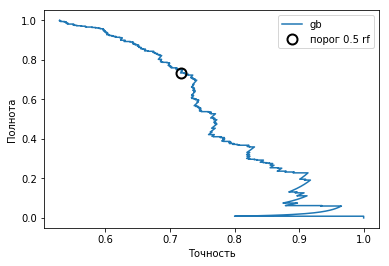

In [65]:
# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(
y_test, best_GB.predict_proba(X_test)[:, 1])

plt.plot(precision_gb, recall_gb, label="gb")
close_default_gb = np.argmin(np.abs(thresholds_gb - 0.5))
plt.plot(precision_gb[close_default_gb], recall_gb[close_default_gb], 'o', c='k',
         markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.show()

In [69]:
y_pred_lower_threshold = best_GB.predict_proba(X_test)[:,1] > .5
print (classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       0.71      0.69      0.70       436
          1       0.72      0.73      0.72       465

avg / total       0.71      0.71      0.71       901



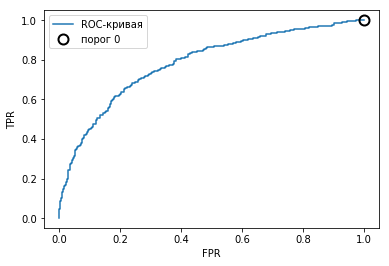

In [60]:
fpr, tpr, threshold = metrics.roc_curve(y_test, best_GB.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
# находим пороговое значение ближайшее к нулю
close_zero = np.argmin(np.abs(threshold))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='порог 0', fillstyle='none', c='k', mew=2)
plt.legend(loc='best')
plt.show()

AUC для градиентного бустинга - 0.775


# Оценка качества признаков

In [150]:
# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (2701, 46)
форма массива X_train_selected: (2701, 23)


In [91]:
mask = select.get_support()
print (mask)
# визуализируем булевы значения: черный - true, булый - false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Индекс')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True False  True False
  True  True False False False False False False False False False False
  True  True  True  True False  True  True  True False False False False
 False False False False  True False False False  True  True False  True
  True False False False  True False False  True False  True  True  True
 False False False False]


Text(0.5,0,'Индекс')

In [92]:
X_test_selected = select.transform(X_test)
print ('Правильность со всеми признаками: {:.3f}'.format(best_GB.score(X_test, y_test)))
best_GB_selected_70 = xgb.XGBClassifier(max_depth=20)
best_GB_selected_70.fit(X_train_selected, y_train)
print ('Правильность с 50% признаками: {:.3f}'.format(best_GB_selected_70.score(X_test_selected, y_test)))

Правильность со всеми признаками: 0.690
Правильность с 50% признаками: 0.681
